# Project 2

# First part

In [ ]:
# All required IMPORTS!

#!pip uninstall scikit-learn -y
#!pip install scikit-learn

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from skimage import io
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
from google.colab import drive
import warnings

warnings.filterwarnings('ignore')

## Cat Faces dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import data

In [ ]:
!tar -xzvf "/content/drive/MyDrive/DeepLearning/dataset-part1.tar.gz" -C "/content/drive/MyDrive/DeepLearning/" 

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_5049.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_1411.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_2397.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_2223.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_2892.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_7455.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_1741.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_9189.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_7802.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_5493.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflag

In [ ]:
path = "/content/drive/MyDrive/DeepLearning/dataset-part1"

# save all of the file names to a list and
# then loop through this list reading your images (numpy arrays) into a new list

print("\nRetrieving cats images from:")
print(path)

folders = glob.glob(path)
i = 0
cat_col = []

for folder in folders:
    for f in glob.glob(folder+'/*.png'):
        i = i +1
        cat_col.append(f)

print("\nCat images found: " + np.str(i))


Retrieving cats images from:
/content/drive/MyDrive/DeepLearning/dataset-part1

Cat images found: 10000


### First plot

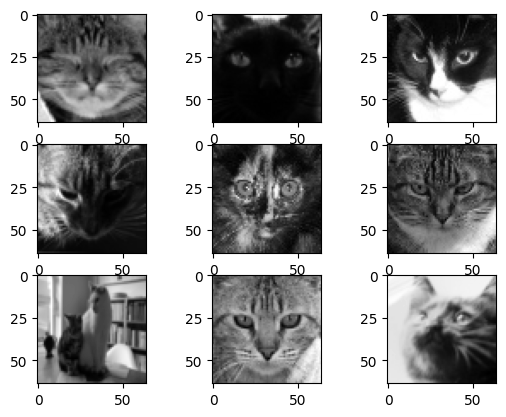

In [ ]:
import cv2

fig, ax = plt.subplots(nrows=3, ncols=3)
axes = ax.flatten()

for i in range(9):
    path=cat_col[i] 
    img = cv2.imread(path)
    axes[i].imshow(rgb2gray(img), cmap=plt.cm.gray)

plt.show()   

In [ ]:
# Set the array in gray 
cat_col_num = []

for i in range(0,10000):
  cat_col_num.append(rgb2gray(imread(cat_col[i])))

In [ ]:
print(len(cat_col_num)) 

10000


### Center mean at 0

In [ ]:
cat_col_num = np.array(cat_col_num)
print(cat_col_num.shape)
cat_resh = cat_col_num.reshape(cat_col_num.shape[0], cat_col_num.shape[1] * cat_col_num.shape[1]) #Reshape 64*64 matrix to 4096 vector
cat_centered = cat_resh - cat_resh.mean(axis=0)
cat_centered -= cat_centered.mean(axis=1).reshape(cat_col_num.shape[0], -1)
print(cat_centered.shape)

(10000, 64, 64)
(10000, 4096)


### Plot similar to the previous plot (For centered faces)

Cat centered original shape:
(10000, 4096)
RESHAPE
(10000, 64, 64)


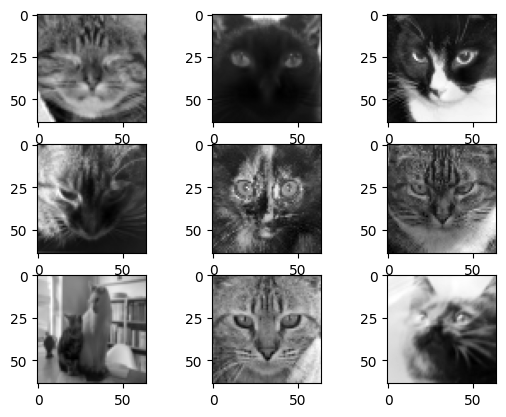

In [ ]:
import cv2

cat_center_reshape = cat_centered.reshape(cat_centered.shape[0], int(cat_centered.shape[1]**0.5), int(cat_centered.shape[1]**0.5)) #Reshape 4096 vector to 64*64 matrix
print('Cat centered original shape:')
print(cat_centered.shape)
print('RESHAPE')
print(cat_center_reshape.shape)
fig, ax = plt.subplots(nrows=3, ncols=3)
axes = ax.flatten()

for i in range(9):
    axes[i].imshow(cat_center_reshape[i], cmap=plt.cm.gray)

plt.show()  

Another way using plot_gallery function from scikit-learn documentation

In [ ]:
n_row, n_col = 3, 3
n_components = n_row * n_col
image_shape = (64, 64)

#Plot gallery function taken from: https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

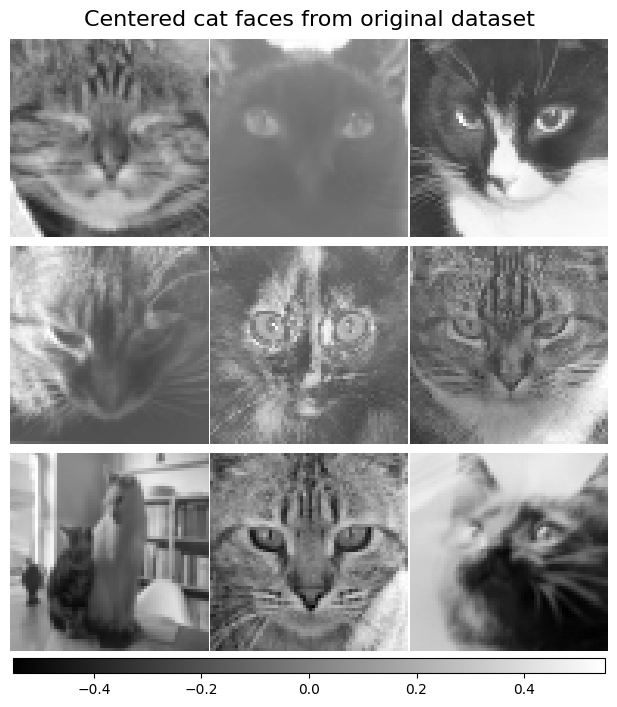

In [ ]:
plot_gallery("Centered cat faces from original dataset", cat_centered[:n_components])

### Eigenvalues plot

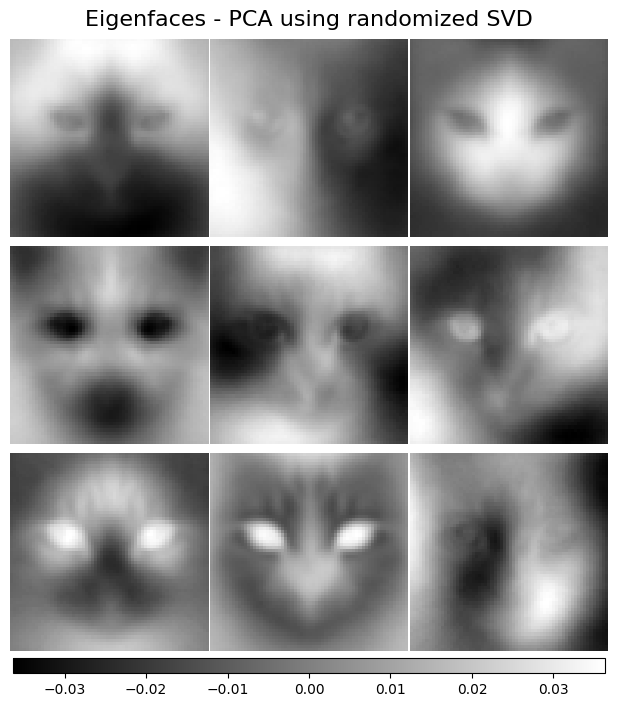

In [ ]:
from sklearn import decomposition

pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="full", whiten=True
)
pca_estimator.fit(cat_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

## Apply PCA

### Apply cross validation to determine the number of components

In [ ]:
# It may take time for a few hours! :) 
# Be patient! 
from sklearn.decomposition import PCA

cv_scores = []
X = cat_centered

for i in range(0, 21): 
    # Apply "full" PCA here:
    pca = PCA(n_components=i,svd_solver='full')
    print('n_components = %d' % i)
    # create cv_scores applying cross_val_score with the data and pca mean value:
    ## You can consider n_jobs=2
    cv_scores.append(np.mean(cross_val_score(pca, X, n_jobs=2)))

n_components = 0
n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16
n_components = 17
n_components = 18
n_components = 19
n_components = 20


### Add last component

In [ ]:
# Add the last component and fit the pca here:
i=21
pca = PCA(n_components=i,svd_solver='full')
print('n_components = %d' % i)
#cv_scores.append(np.mean(cross_val_score(pca, X, n_jobs=2)))
X2D = pca.fit_transform(X)  #Fit pca here


n_components = 21


### Form reconstruction error plot

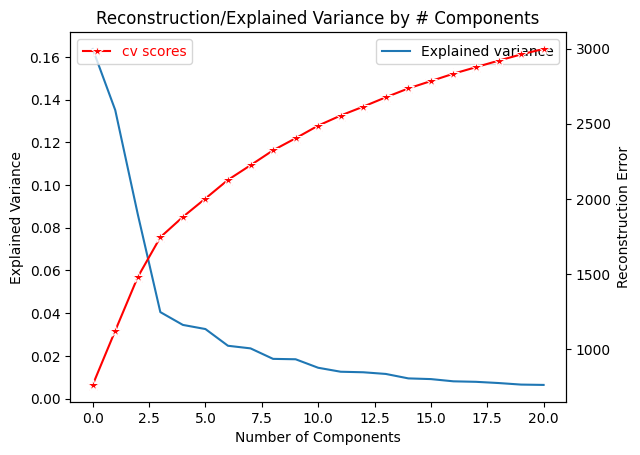

In [ ]:
# Form the recunstruction Error here:
rec_error = pd.DataFrame({'n_components': np.arange(0,21),
'reconst error': cv_scores,
'explained var ratio': pca.explained_variance_ratio_})

# Plot it here: 
fig, ax = plt.subplots()
sns.lineplot(data=rec_error, x = 'n_components', 
             y = 'explained var ratio', label='Explained variance')

# Use twin Axes here: 
ax2 = plt.twinx()
sns.lineplot(data=rec_error, x = 'n_components', 
             y = 'reconst error', color="r", 
             marker='*', markersize=9,
             label='cv scores',ax=ax2)

plt.legend(labelcolor="linecolor")
plt.title('Reconstruction/Explained Variance by # Components')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance')
ax2.set_ylabel('Reconstruction Error')
plt.show()

### PCA Transform for 20 components

Transform data back to its original space

In [ ]:
# Transform, inverse and then plot it here:
X2D_transformed = pca.inverse_transform(X2D)

In [ ]:
X2D_transformed.shape

(10000, 4096)

### Plot by 20 principal components

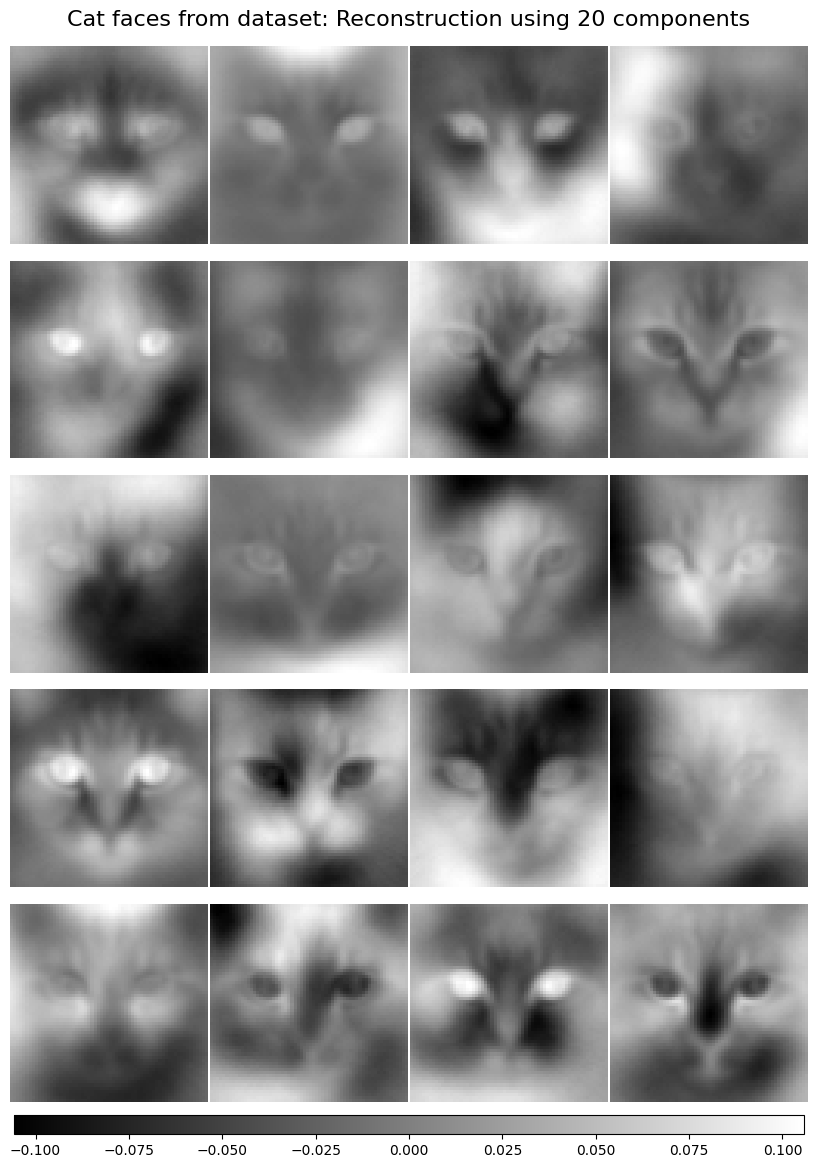

In [ ]:
n_col=4
plot_gallery("Cat faces from dataset: Reconstruction using 20 components", X2D_transformed[:20],n_col=4, n_row=5)

Another way:

Cat transformed original shape:
(10000, 4096)
RESHAPE
(10000, 64, 64)


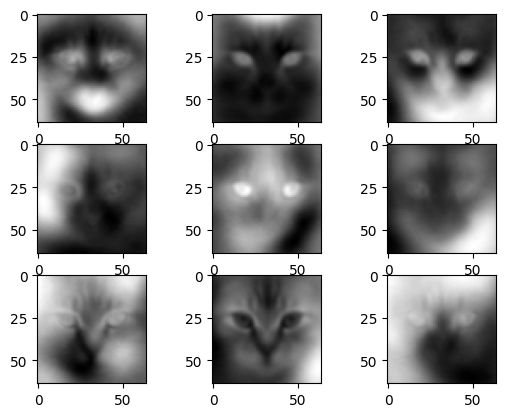

In [ ]:
import cv2

cat_transformed_reshape = X2D_transformed.reshape(X2D_transformed.shape[0], int(X2D_transformed.shape[1]**0.5), int(X2D_transformed.shape[1]**0.5)) #Reshape 4096 vector to 64*64 matrix
print('Cat transformed original shape:')
print(X2D_transformed.shape)
print('RESHAPE')
print(cat_transformed_reshape.shape)
fig, ax = plt.subplots(nrows=3, ncols=3)
axes = ax.flatten()

for i in range(9):
    axes[i].imshow(cat_transformed_reshape[i], cmap=plt.cm.gray)

plt.show()  


# Second Part

## Data Preprocessing

In [ ]:
#the file is uploaded into the drive, so we connect to the drive first
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip the data file
!unzip /content/drive/MyDrive/DeepLearning/modcloth_final_data.json.zip


Archive:  /content/drive/MyDrive/DeepLearning/modcloth_final_data.json.zip
  inflating: modcloth_final_data.json  
  inflating: __MACOSX/._modcloth_final_data.json  


In [ ]:
#turn the json format into a dataframe
data=pd.read_json('/content/modcloth_final_data.json',lines=True)
data

item_id  waist  size  quality cup size  hips  bra size   category bust  \
0       123373   29.0     7      5.0        d  38.0      34.0        new   36   
1       123373   31.0    13      3.0        b  30.0      36.0        new  NaN   
2       123373   30.0     7      2.0        b   NaN      32.0        new  NaN   
3       123373    NaN    21      5.0     dd/e   NaN       NaN        new  NaN   
4       123373    NaN    18      5.0        b   NaN      36.0        new  NaN   
...        ...    ...   ...      ...      ...   ...       ...        ...  ...   
82785   807722    NaN     8      4.0        b   NaN      36.0  outerwear  NaN   
82786   807722    NaN    12      5.0    ddd/f   NaN      34.0  outerwear  NaN   
82787   807722    NaN    12      5.0   dddd/g  36.0      32.0  outerwear  NaN   
82788   807722    NaN    12      4.0      NaN   NaN       NaN  outerwear  NaN   
82789   807722    NaN     4      4.0        d  39.0      32.0  outerwear  NaN   

        height         user_name         length    fit  user_id  shoe size  \
0      5ft 6in             Emily     just right  small   991571        NaN   
1      5ft 2in  sydneybraden2001     just right  small   587883        NaN   
2      5ft 7in             Ugggh  slightly long  small   395665        9.0   
3          NaN      alexmeyer626     just right    fit   875643        NaN   
4      5ft 2in        dberrones1  slightly long  small   944840        NaN   
...        ...               ...            ...    ...      ...        ...   
82785  5ft 8in          Jennifer     just right    fit   727820        8.5   
82786  5ft 5in             Kelli  slightly long  small   197040        NaN   
82787  5ft 4in          elacount     just right    fit   102493        NaN   
82788  5ft 3in      jennaklinner     just right    fit   756491        NaN   
82789      6ft   maireadsteadman     just right    fit    78305        NaN   

      shoe width             review_summary  \
0            NaN                        NaN   
1            NaN                        NaN   
2            NaN                        NaN   
3            NaN                        NaN   
4            NaN                        NaN   
...          ...                        ...   
82785    average               Cute jacket!   
82786        NaN   It's a beautiful jacket.   
82787        NaN  I love this blazer. It is   
82788        NaN  I love this blazer!! I wo   
82789        NaN  I love this piece. I'm re   

                                             review_text  
0                                                    NaN  
1                                                    NaN  
2                                                    NaN  
3                                                    NaN  
4                                                    NaN  
...                                                  ...  
82785                                       Cute jacket!  
82786  It's a beautiful jacket. I love how it's knit ...  
82787  I love this blazer. It is a great office piece...  
82788  I love this blazer!! I wore it yesterday and g...  
82789       I love this piece. I'm really happy with it!  

[82790 rows x 18 columns]

In [ ]:
#Drop the unrelatted features for PCA and t-SNE training
col_drop=['item_id','user_name','user_id','fit','review_summary', 'review_text','quality']
X=data.drop(col_drop,axis=1)
X.head()

waist  size cup size  hips  bra size category bust   height         length  \
0   29.0     7        d  38.0      34.0      new   36  5ft 6in     just right   
1   31.0    13        b  30.0      36.0      new  NaN  5ft 2in     just right   
2   30.0     7        b   NaN      32.0      new  NaN  5ft 7in  slightly long   
3    NaN    21     dd/e   NaN       NaN      new  NaN      NaN     just right   
4    NaN    18        b   NaN      36.0      new  NaN  5ft 2in  slightly long   

   shoe size shoe width  
0        NaN        NaN  
1        NaN        NaN  
2        9.0        NaN  
3        NaN        NaN  
4        NaN        NaN

In [ ]:
#encode the ordinal variable from strings to categoties
mod_noms=['cup size','category','length','shoe width']
enc=OrdinalEncoder()
X[mod_noms]=enc.fit_transform(X[mod_noms])

#reorder the column to match the format in the example
col_order=['waist', 'size', 'hips','bra size','bust', 'height','shoe size','cup size', 'category' ,'length',    'shoe width']
X=X[col_order]

#For the bust data value, there is an anomoly which is '37-39', we take the middle value in this case
X.bust.iloc[37313]='38'
X.head()

waist  size  hips  bra size bust   height  shoe size  cup size  category  \
0   29.0     7  38.0      34.0   36  5ft 6in        NaN       4.0       2.0   
1   31.0    13  30.0      36.0  NaN  5ft 2in        NaN       2.0       2.0   
2   30.0     7   NaN      32.0  NaN  5ft 7in        9.0       2.0       2.0   
3    NaN    21   NaN       NaN  NaN      NaN        NaN       5.0       2.0   
4    NaN    18   NaN      36.0  NaN  5ft 2in        NaN       2.0       2.0   

   length  shoe width  
0     0.0         NaN  
1     0.0         NaN  
2     1.0         NaN  
3     0.0         NaN  
4     1.0         NaN

In [ ]:
#Change bust and height to numeric value

def height_to_inches(cell_string):
    if(type(cell_string) == str):
        split_strings = cell_string.split()
        if(len(split_strings) > 1):
          if(split_strings[1][1] == 'i'):
            float_value = (float(split_strings[0][0])*12)+float(split_strings[1][0])
          else:
            float_value = (float(split_strings[0][0])*12)+10+float(split_strings[1][1])
        else:
          float_value = float(split_strings[0][0])*12
    else:
        float_value = np.nan
    return float_value

X['height'] = X['height'].apply(height_to_inches)

def bust_to_float(cell_string):
    if(type(cell_string) == str):
        float_value = float(cell_string)
    else:
        float_value = np.nan
    return float_value

X['bust'] = X['bust'].apply(bust_to_float)

#Cleaned_data preview
X.head()


waist  size  hips  bra size  bust  height  shoe size  cup size  category  \
0   29.0     7  38.0      34.0  36.0    66.0        NaN       4.0       2.0   
1   31.0    13  30.0      36.0   NaN    62.0        NaN       2.0       2.0   
2   30.0     7   NaN      32.0   NaN    67.0        9.0       2.0       2.0   
3    NaN    21   NaN       NaN   NaN     NaN        NaN       5.0       2.0   
4    NaN    18   NaN      36.0   NaN    62.0        NaN       2.0       2.0   

   length  shoe width  
0     0.0         NaN  
1     0.0         NaN  
2     1.0         NaN  
3     0.0         NaN  
4     1.0         NaN

## Code

In [ ]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.multivariate.pca import PCA
from sklearn.preprocessing import StandardScaler

pc = PCA(X, ncomp=2, method='nipals', missing='fill-em')

pc.factors

comp_0    comp_1
0     -0.001565  0.000327
1     -0.002351 -0.002849
2     -0.002653  0.004138
3      0.003271 -0.004078
4     -0.000379 -0.001876
...         ...       ...
82785 -0.001758  0.003503
82786  0.000300 -0.001104
82787 -0.000995 -0.003834
82788 -0.000201 -0.003217
82789 -0.001901  0.006926

[82790 rows x 2 columns]

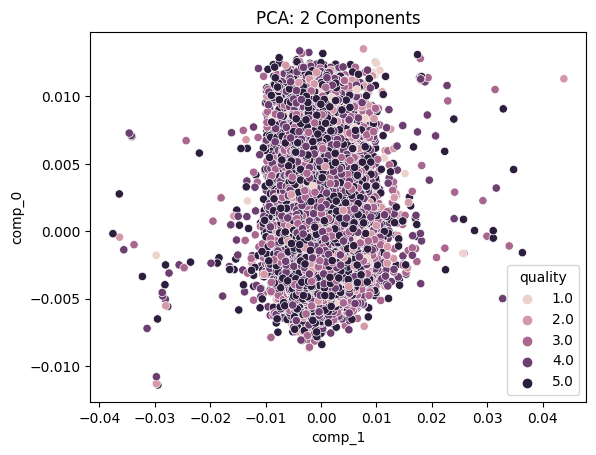

In [ ]:
sns.scatterplot(x=pc.factors['comp_1'], y=pc.factors['comp_0'], hue=data['quality'])

plt.title("PCA: 2 Components")
plt.xlabel('comp_1')
plt.ylabel('comp_0')

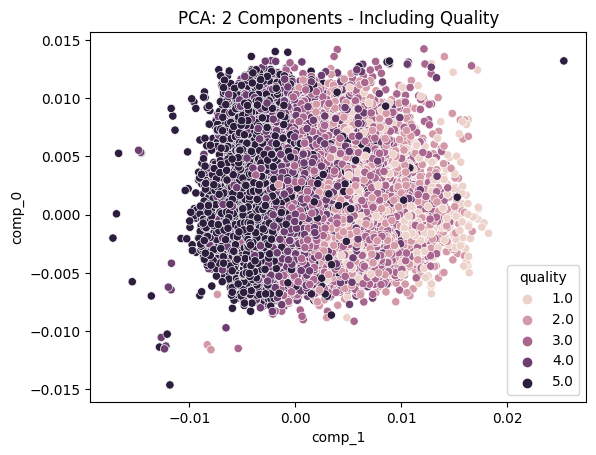

In [ ]:
X['quality'] = data['quality']

pc2 = PCA(X, ncomp=2, method='nipals', missing='fill-em')

sns.scatterplot(x=pc2.factors['comp_1'], y=pc2.factors['comp_0'], hue=data['quality'])

plt.title("PCA: 2 Components - Including Quality")
plt.xlabel('comp_1')
plt.ylabel('comp_0')

# Third part

In [ ]:
#preview of the data
data.head()

item_id  waist  size  quality cup size  hips  bra size category bust  \
0   123373   29.0     7      5.0        d  38.0      34.0      new   36   
1   123373   31.0    13      3.0        b  30.0      36.0      new  NaN   
2   123373   30.0     7      2.0        b   NaN      32.0      new  NaN   
3   123373    NaN    21      5.0     dd/e   NaN       NaN      new  NaN   
4   123373    NaN    18      5.0        b   NaN      36.0      new  NaN   

    height         user_name         length    fit  user_id  shoe size  \
0  5ft 6in             Emily     just right  small   991571        NaN   
1  5ft 2in  sydneybraden2001     just right  small   587883        NaN   
2  5ft 7in             Ugggh  slightly long  small   395665        9.0   
3      NaN      alexmeyer626     just right    fit   875643        NaN   
4  5ft 2in        dberrones1  slightly long  small   944840        NaN   

  shoe width review_summary review_text  
0        NaN            NaN         NaN  
1        NaN            NaN         NaN  
2        NaN            NaN         NaN  
3        NaN            NaN         NaN  
4        NaN            NaN         NaN

## LDA

In [ ]:
#initial set-up for the lda training
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

#use the review_text as the dataset
text_data=data['review_text']
data_samples=text_data.dropna()
text_data.describe()

count        76065
unique       73313
top       Love it!
freq           153
Name: review_text, dtype: object

### define the plot_top_words function

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    #plt.savefig('topics.png')
    plt.show()

### train the LDA and plot topics

done in 98.234s.


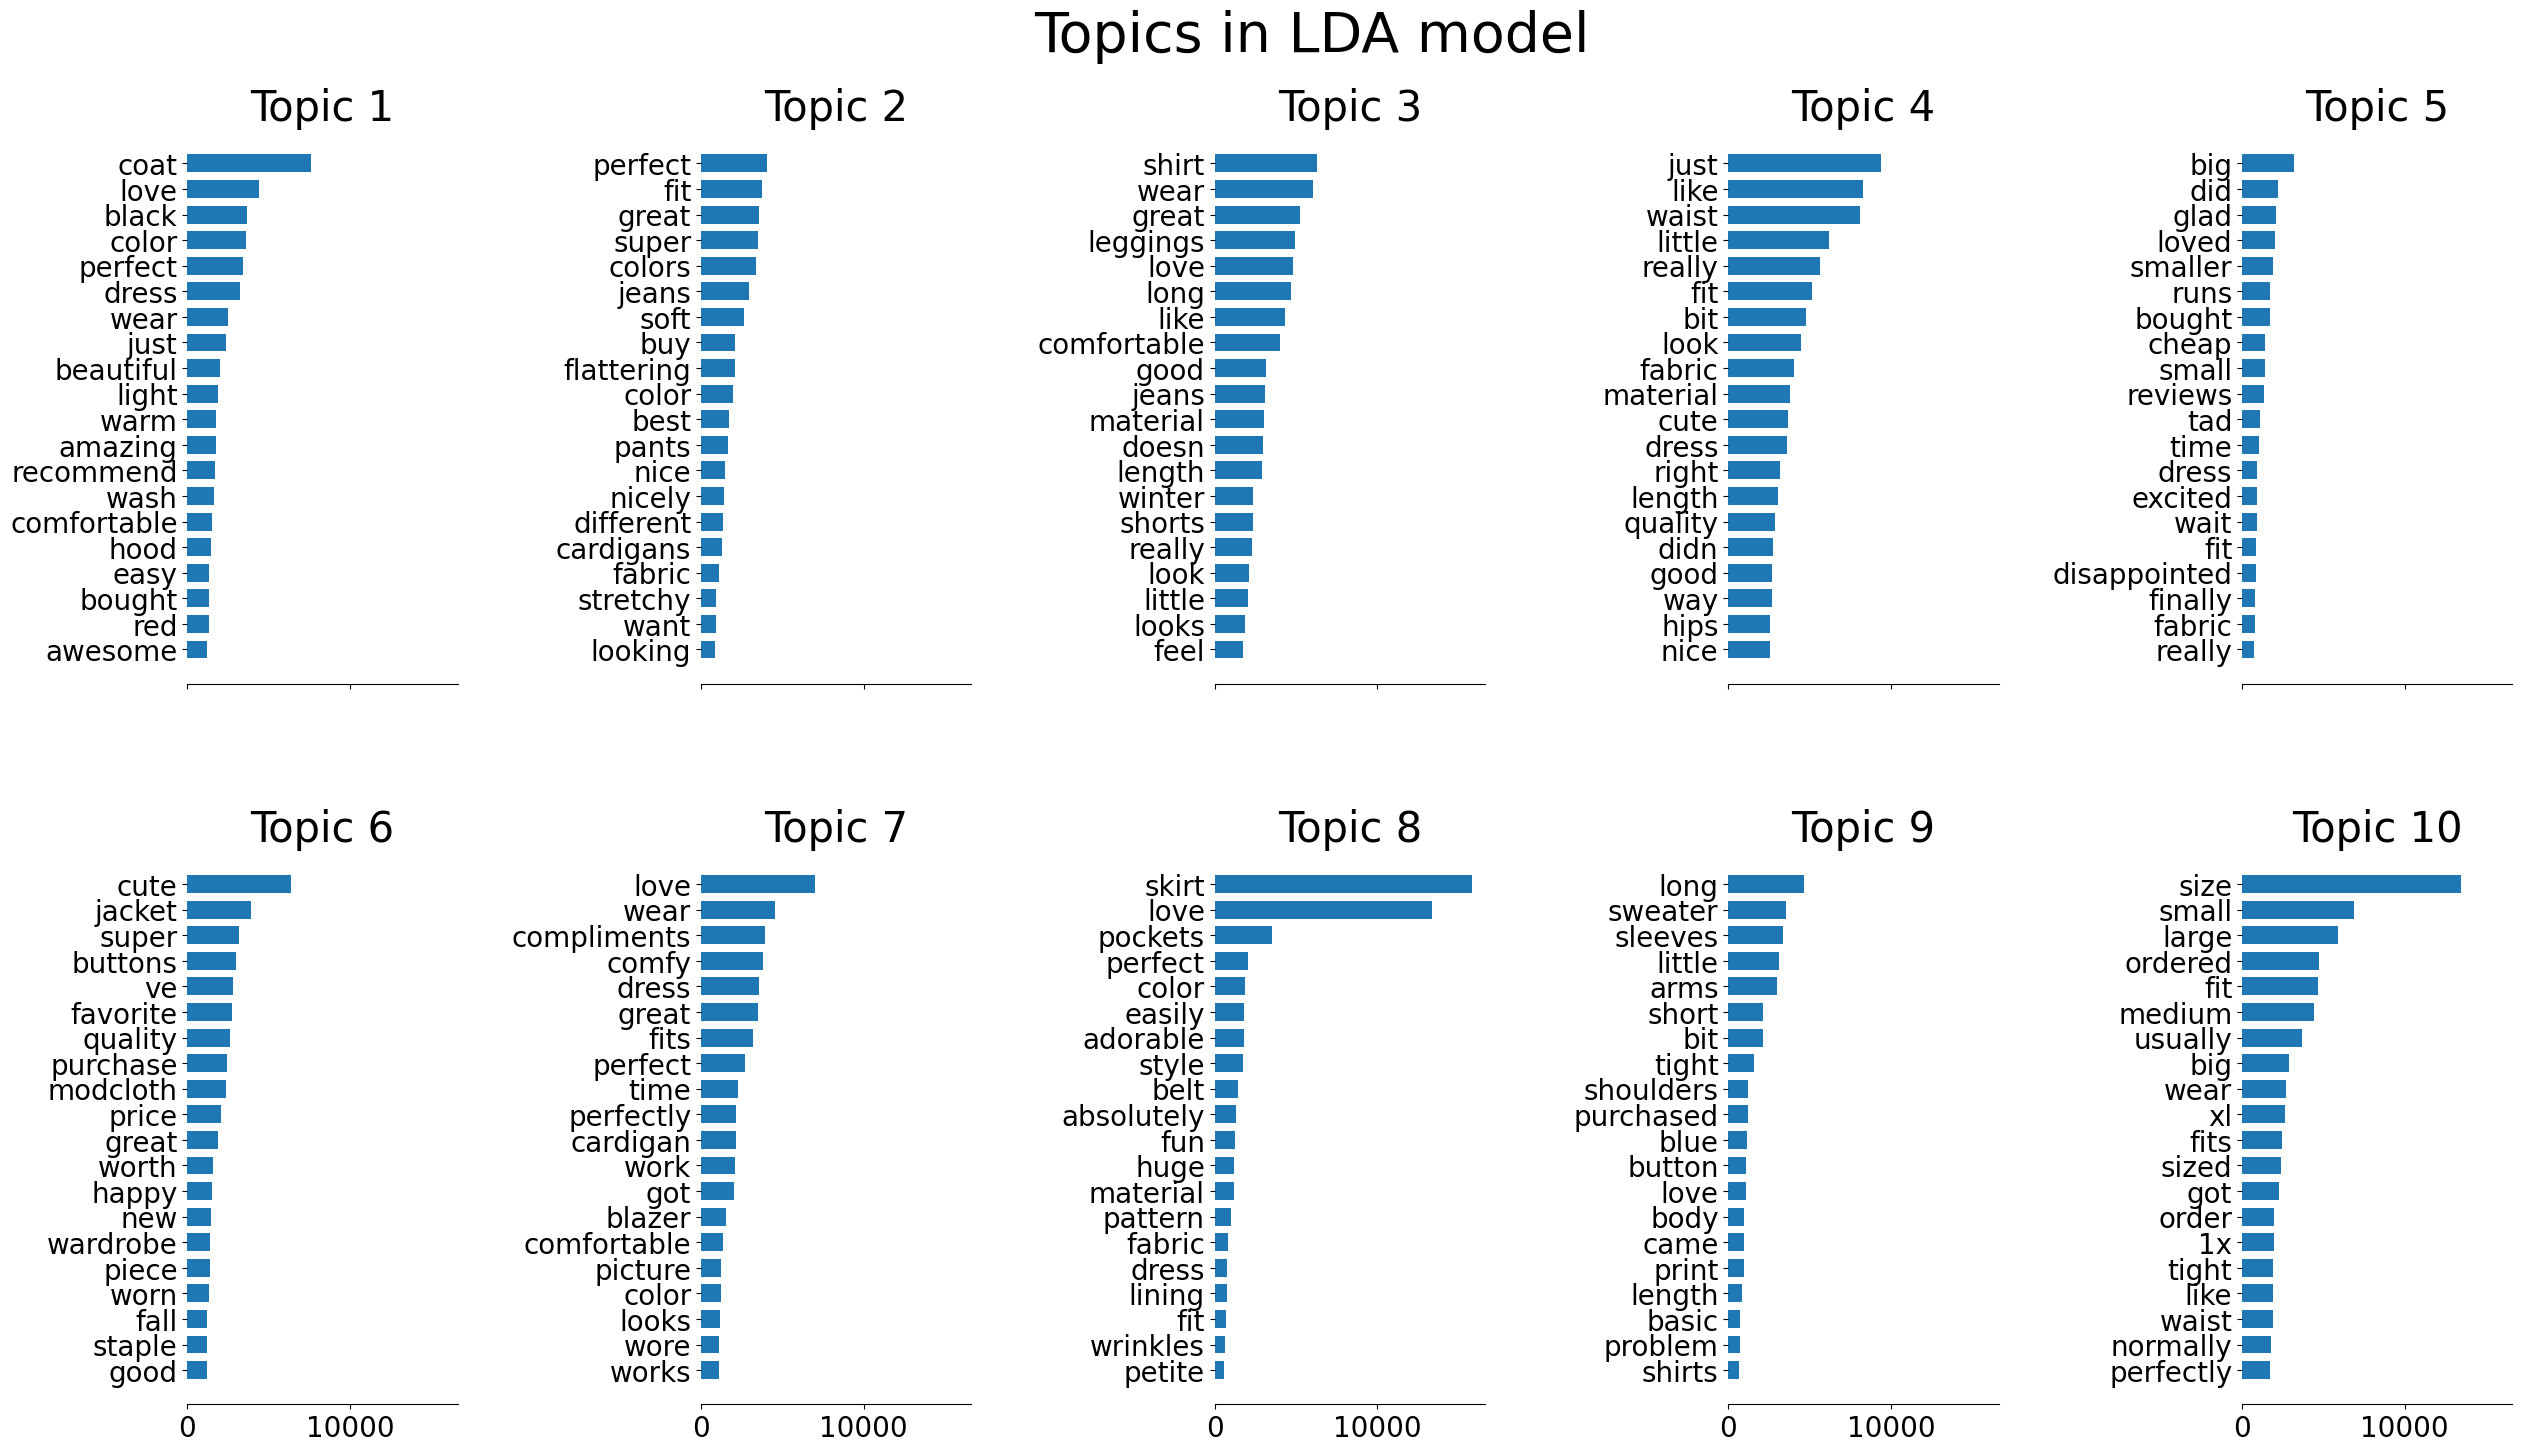

In [ ]:
#train the vectorizer
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)

#train the lda model
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

#create the topic plot
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

## tSNE and Manifold Learning

### data

In [ ]:
#prepare data
no_missing_data=X.dropna()
no_missing_data

waist  size  hips  bra size  bust  height  shoe size  cup size  \
1069    30.0     8  40.0      36.0  36.0    67.0        8.5       3.0   
1750    27.0     8  34.0      34.0  38.0    59.0        8.0       7.0   
1751    33.0    12  36.0      38.0  38.0    63.0        7.5       6.0   
2336    49.0    32  51.0      42.0  51.0    66.0        9.5       5.0   
2367    31.0     8  41.0      34.0  36.0    66.0        8.5       3.0   
...      ...   ...   ...       ...   ...     ...        ...       ...   
80851   31.0    15  39.0      36.0  39.0    66.0        8.0       6.0   
80932   36.0    15  42.0      38.0  44.0    63.0        6.5       4.0   
80942   30.0     8  40.0      36.0  35.0    64.0        8.0       3.0   
82654   30.0    20  39.0      42.0  32.0    64.0        7.5       2.0   
82720   38.0    26  50.0      38.0  43.0    72.0       10.5       3.0   

       category  length  shoe width  
1069        2.0     2.0         0.0  
1750        2.0     0.0         2.0  
1751        2.0     0.0         2.0  
2336        2.0     0.0         2.0  
2367        2.0     0.0         0.0  
...         ...     ...         ...  
80851       4.0     0.0         2.0  
80932       3.0     0.0         2.0  
80942       3.0     0.0         2.0  
82654       3.0     0.0         2.0  
82720       3.0     0.0         2.0  

[557 rows x 11 columns]

### intial training and results of t-SNE

In [ ]:
#t-SNE parameters
n_component=2;perp=40;niter=5000;learn_rate=10;n_job=2;random=42

In [ ]:
#t-SNE training
tsne=TSNE(n_components=n_component,perplexity=perp,n_iter=niter,learning_rate=learn_rate,n_jobs=n_job,
          random_state=random)
tsne_embd=tsne.fit_transform(no_missing_data)

<Axes: title={'center': 'tSNE with perplexity=40'}>

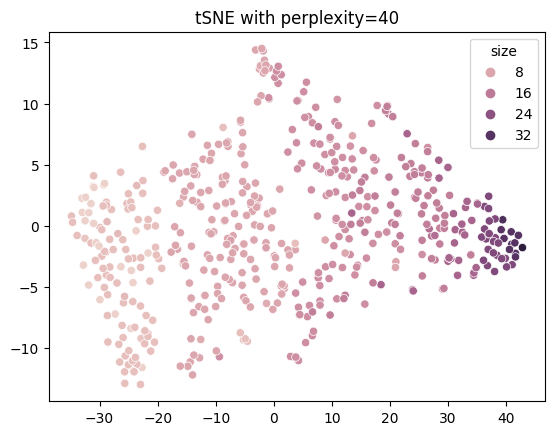

In [ ]:
#Plot the initial results with respect to size
plt.title('tSNE with perplexity=40')
sns.scatterplot(x=tsne_embd[:,0],
                y=tsne_embd[:,1],
                hue='size',
                data=no_missing_data)

### varying perplexities

In [ ]:
#try different perplexities in the range [5,50] suggested by the article
perplexities=list(range(5,55,5))
def get_train_results(params):
  results=[]
  for p in params:
    tsne=TSNE(n_components=n_component,perplexity=p,n_iter=niter,learning_rate=learn_rate,n_jobs=n_job,random_state=random)
    results.append(tsne.fit_transform(no_missing_data))
  return results
embds=get_train_results(perplexities)


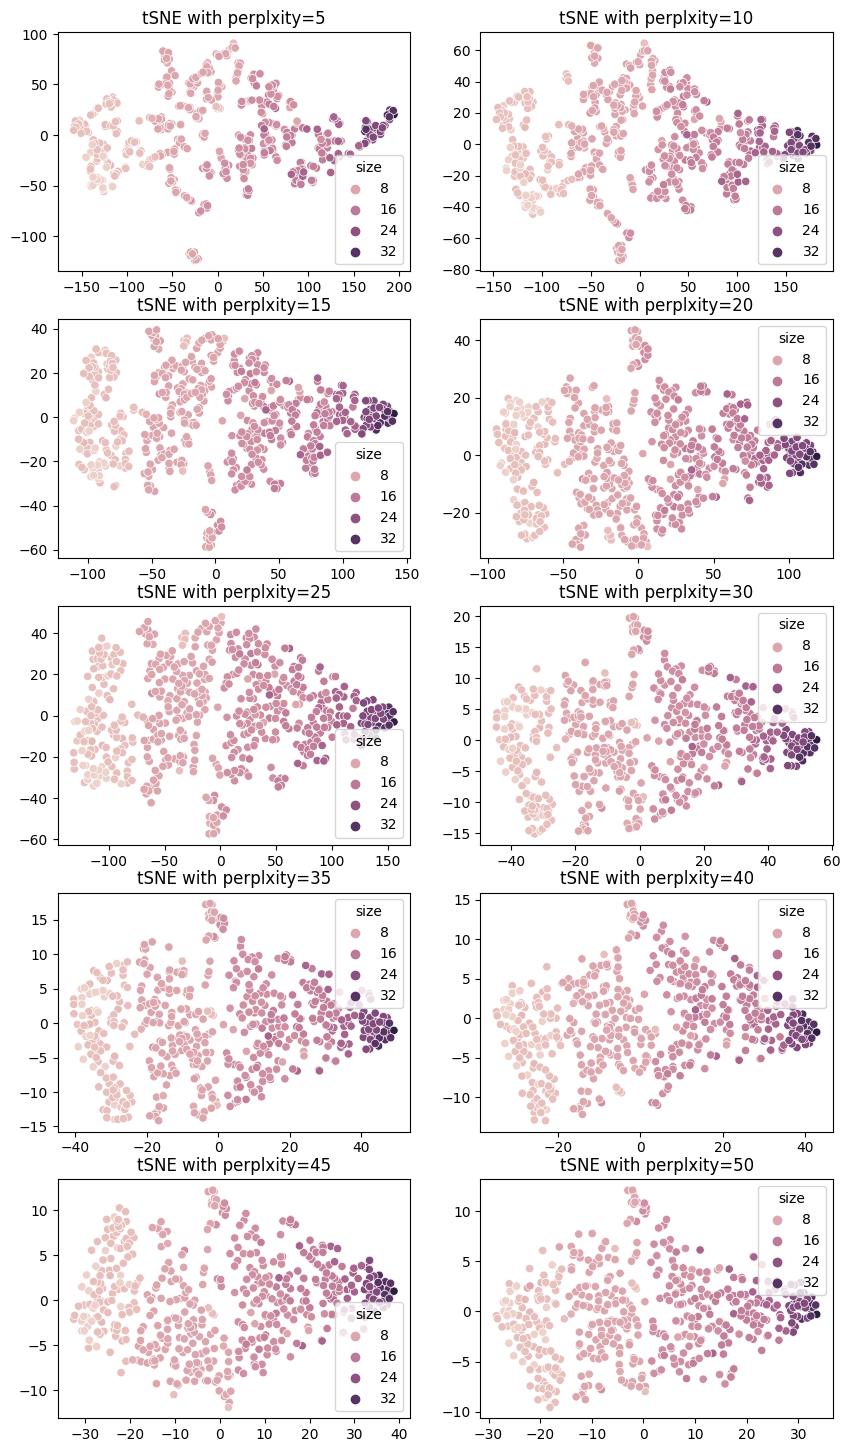

In [ ]:
#plot the results with respect to size under different perplexities to see if there are improvements
plt.figure(figsize=(10,18))
for i in range(len(perplexities)):
  plt.subplot(5,2,i+1)
  plt.title('tSNE with perplxity='+str(perplexities[i]))
  sns.scatterplot(x=embds[i][:,0],
                  y=embds[i][:,1],
                  hue='size',
                  data=no_missing_data)
  

It seems that perplexity at 40 works fine. Higher perplexity does not provide significant additional information of the pattern

### scatterplot of embedding components with respect to features

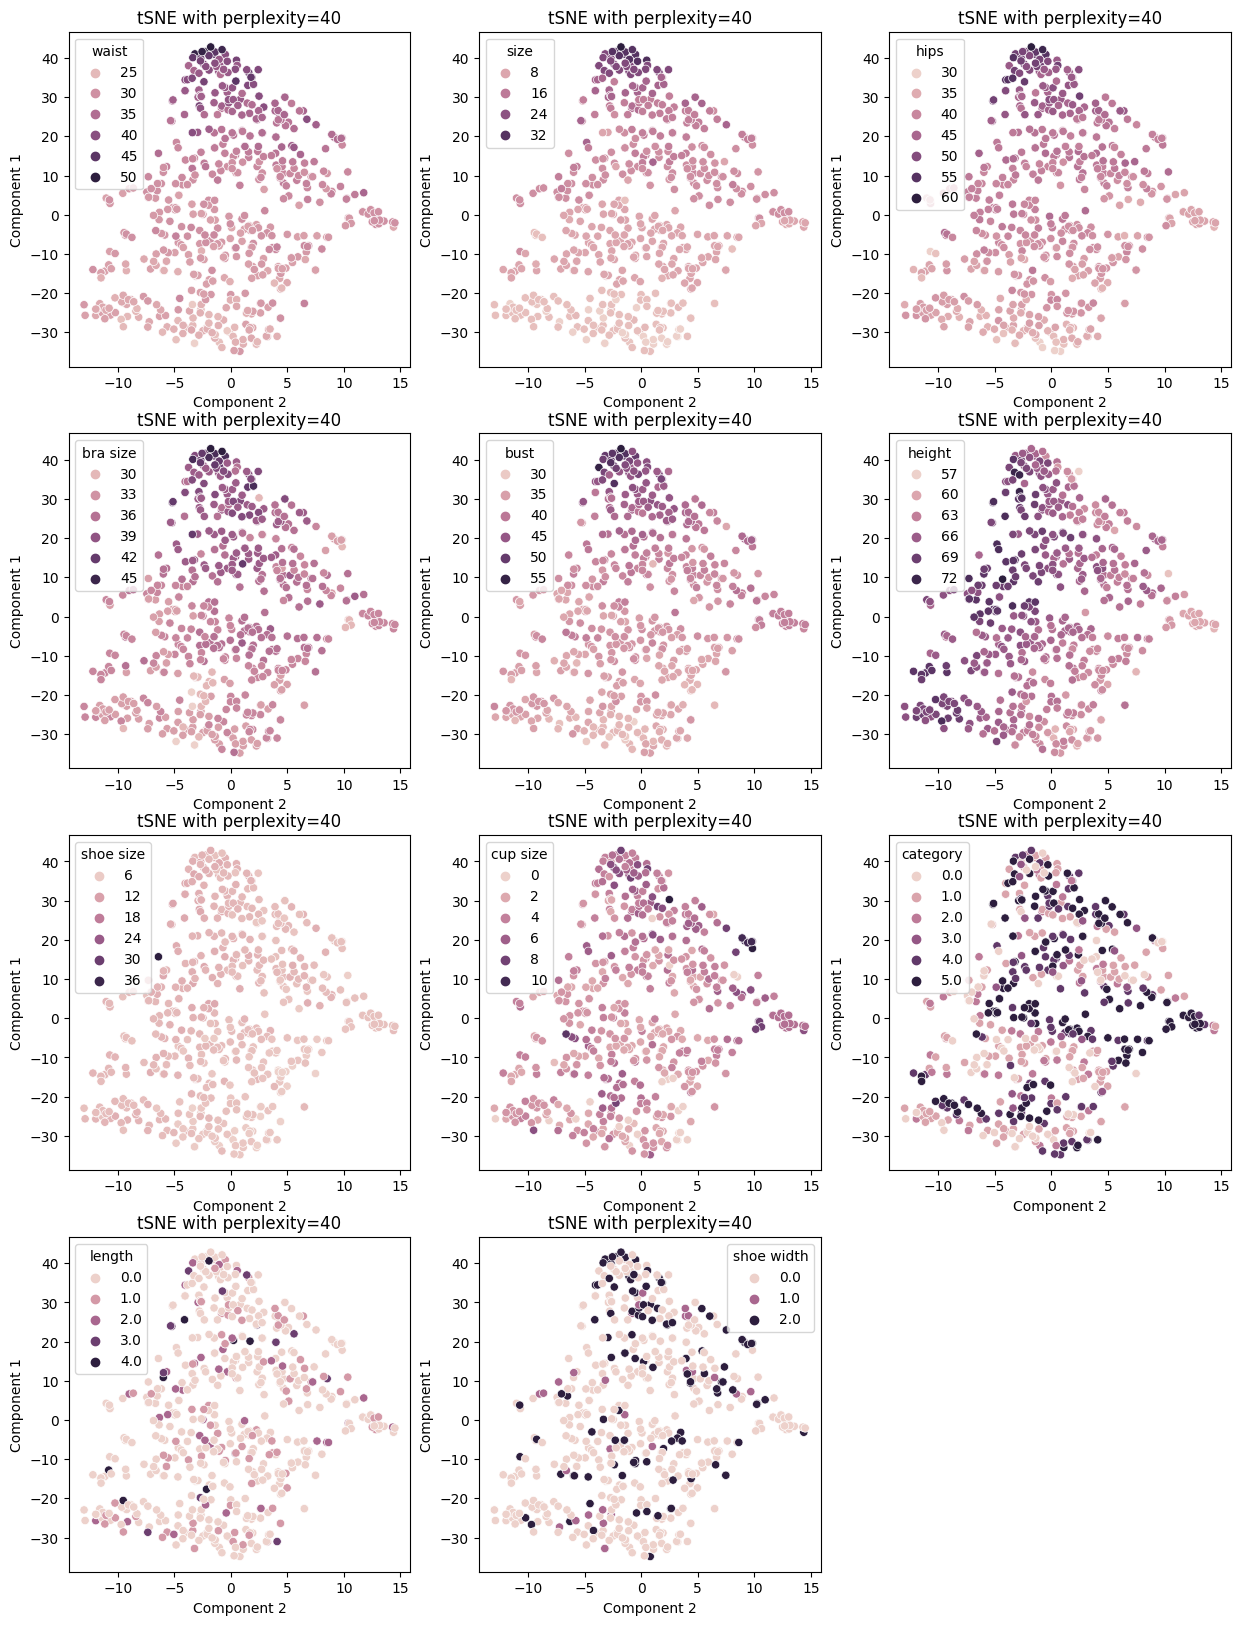

In [ ]:
#use perplexity =40 and keep other setting the same, plot the two components with resepect to each feature
#Note that in this case, x-axis is the second component, y-axis is the first component.

embd_id=perplexities.index(40)
features=no_missing_data.columns

plt.figure(figsize=(15,20))
for i in range(len(features)):
  plt.subplot(4,3,i+1)
  plt.title('tSNE with perplexity='+str(perplexities[embd_id]))
  sns.scatterplot(
                  x=embds[embd_id][:,1],
                  y=embds[embd_id][:,0],
                  hue=features[i],
                  data=no_missing_data
                  )
  plt.xlabel('Component 2')
  plt.ylabel('Component 1')
